In [41]:
#Credit for code here: https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model
df = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv")
df["Image"] = df["ID"].str.slice(stop=12)
df["Diagnosis"] = df["ID"].str.slice(start=13)

duplicates_to_remove = [
    1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
    312468,  312469,  312470,  312471,  312472,  312473,
    2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
    3032994, 3032995, 3032996, 3032997, 3032998, 3032999
]

df = df.drop(index=duplicates_to_remove)
df = df.reset_index(drop=True)

df = df.loc[:, ["Label", "Diagnosis", "Image"]]
df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)

# 1. Bias in the dataset

In [51]:
print(df['Label']['any'].value_counts())

0    577155
1     97103
Name: any, dtype: int64


We can clearly see there is a strong bias in the dataset (there are many more positive than negative samples).

In [52]:
df['Label']['any'].value_counts()/len(df.index)

0    0.855985
1    0.144015
Name: any, dtype: float64

## Conclusion

85.6% of samples are negative,

14,4% of samples are positive.

There are ~6 times more negative than positive samples.

# 2. Are different diagnoses equaly likely?

In [71]:
diagnoses = df['Label'].sum()/df['Label']['any'].sum()
diagnoses = diagnoses.drop('any')

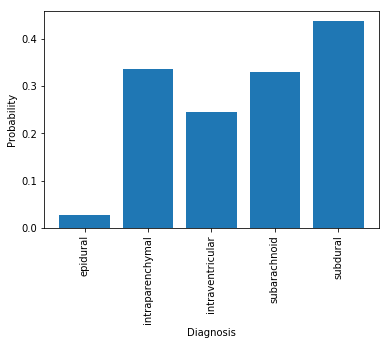

In [86]:
import matplotlib.pyplot as plt
plt.bar(diagnoses.keys(), height = diagnoses.values)
plt.xlabel('Diagnosis')
plt.ylabel('Probability')
plt.xticks(rotation='vertical')
plt.show()

In [96]:
df.sum()

       Diagnosis       
Label  any                 97103
       epidural             2761
       intraparenchymal    32564
       intraventricular    23766
       subarachnoid        32122
       subdural            42496
dtype: int64

## Conclusion: 
It looks like epidural hemorrhage is the least likely diagnosis (by an order of magnitude)

# 3. Are there images with multiple diagnoses?

In [99]:
df[df.sum(axis=1)>2]

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_0002a38ad     1        0                0                0            1   
ID_0005d340e     1        0                0                1            1   
ID_00094b19b     1        0                1                0            1   
ID_000a050f3     1        0                0                0            1   
ID_000d66d9e     1        0                0                0            1   
...            ...      ...              ...              ...          ...   
ID_fff92ad89     1        0                1                1            0   
ID_fff9bb57a     1        1                1                1            0   
ID_fffa58f70     1        0                1                1            0   
ID_fffb124e6     1        0                0                0            1   
ID_fffc60817     1        0                1                1            0   

                       
Diagnosis    subdural  
Image                  
ID_0002a38ad        1  
ID_0005d340e        0  
ID_00094b19b        0  
ID_000a050f3        1  
ID_000d66d9e        1  
...               ...  
ID_fff92ad89        0  
ID_fff9bb57a        0  
ID_fffa58f70        1  
ID_fffb124e6        1  
ID_fffc60817        0  

[29134 rows x 6 columns]

In [106]:
len(df[df.sum(axis=1)>1]) #number of images with any diagnosis.

97103

In [101]:
len(df[df.sum(axis=1)==6]) #number of images with all 6 kinds of hemorrhage

20

# Conclusion:
There are 29134 images with more than one diagnosis. (about 5% of all images and 30% of diagnoses).
It's a very important observation and changes the loss function we should use.
We need to use binary crossentropy, not categorical crossentropy as the loss function for our model.